In [1]:
import tensorflow as tf
import os
import glob
import shutil
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from tqdm.notebook import tqdm
import pydicom  as dicom
import cv2
from PIL import Image


from sklearn.model_selection import KFold,StratifiedKFold


In [2]:
input_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_labels_file = "train_labels.csv"

train_labels = pd.read_csv(input_path + train_labels_file)
train_labels

 # MGMT_Class = 0 refers to people who do not have the MGMT promoter methylation. 
 # MGMT_Class = 1 appears to be someone who has the MGMT promoter methylation.

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [3]:
test_labels_file = "sample_submission.csv"

test_labels = pd.read_csv(input_path + test_labels_file)
test_labels

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [4]:
def plot_examples(row, cat):

    folder = str(train_labels.loc[row, 'BraTS21ID']).zfill(5)
    path_file = ''.join([input_path, 'train/', folder, '/', cat, '/'])
    images = os.listdir(path_file)
    
    fig, axs = plt.subplots(1, 5, figsize=(30, 10))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    
    for num in range(5):
        data_file = dicom.dcmread(path_file+images[num])
        img = data_file.pixel_array
        axs[num].imshow(img, cmap='gray')
        axs[num].set_title(cat+' '+images[num])
        axs[num].set_xticklabels([])
        axs[num].set_yticklabels([])
        axs[num].grid(False)
    
    plt.suptitle("MRI "+cat+" Scan for patient "+folder,
                 fontsize=18, color="#0b0a2d",
                 x=.5, y=.8)

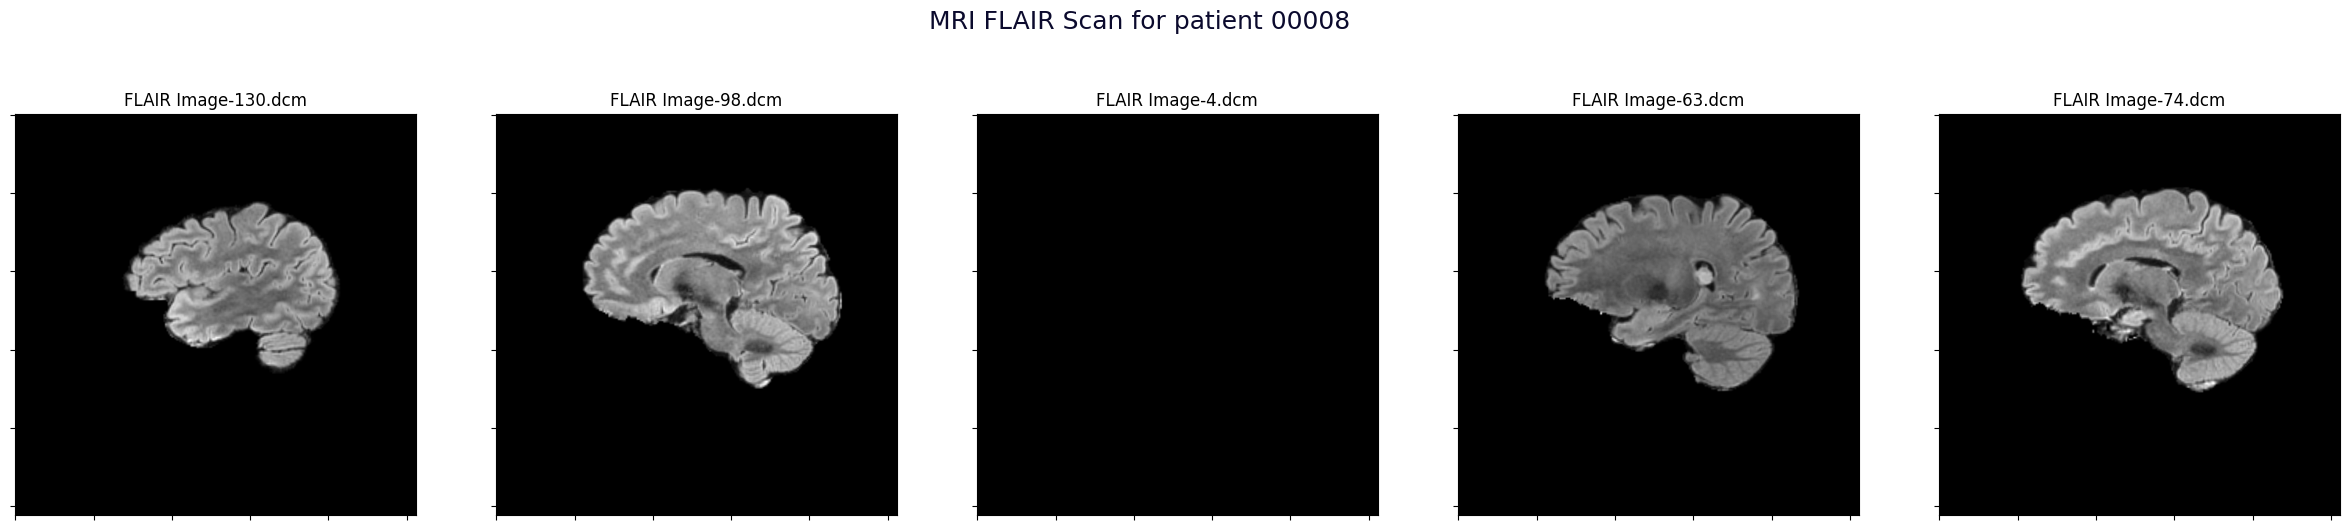

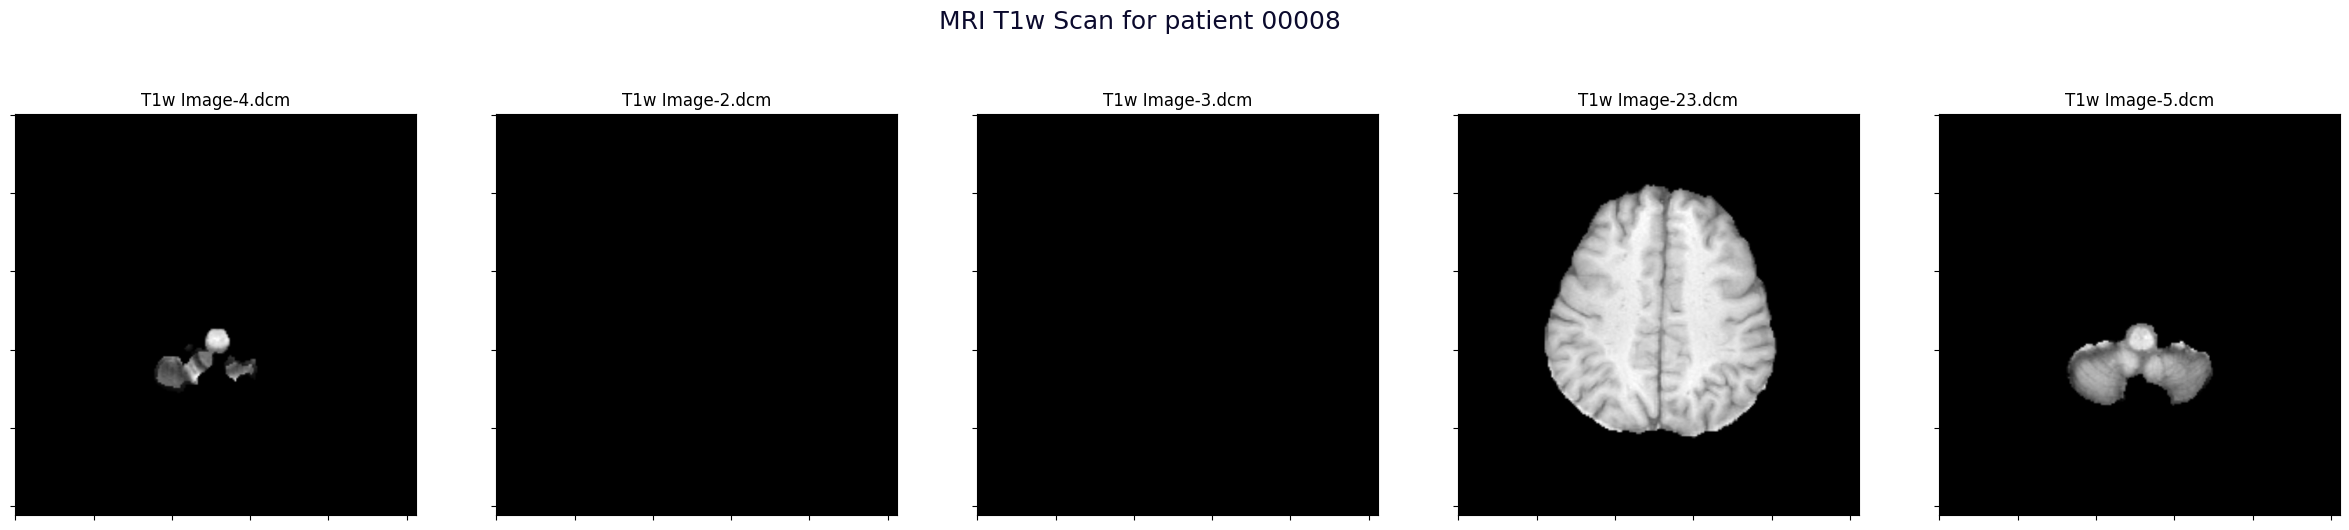

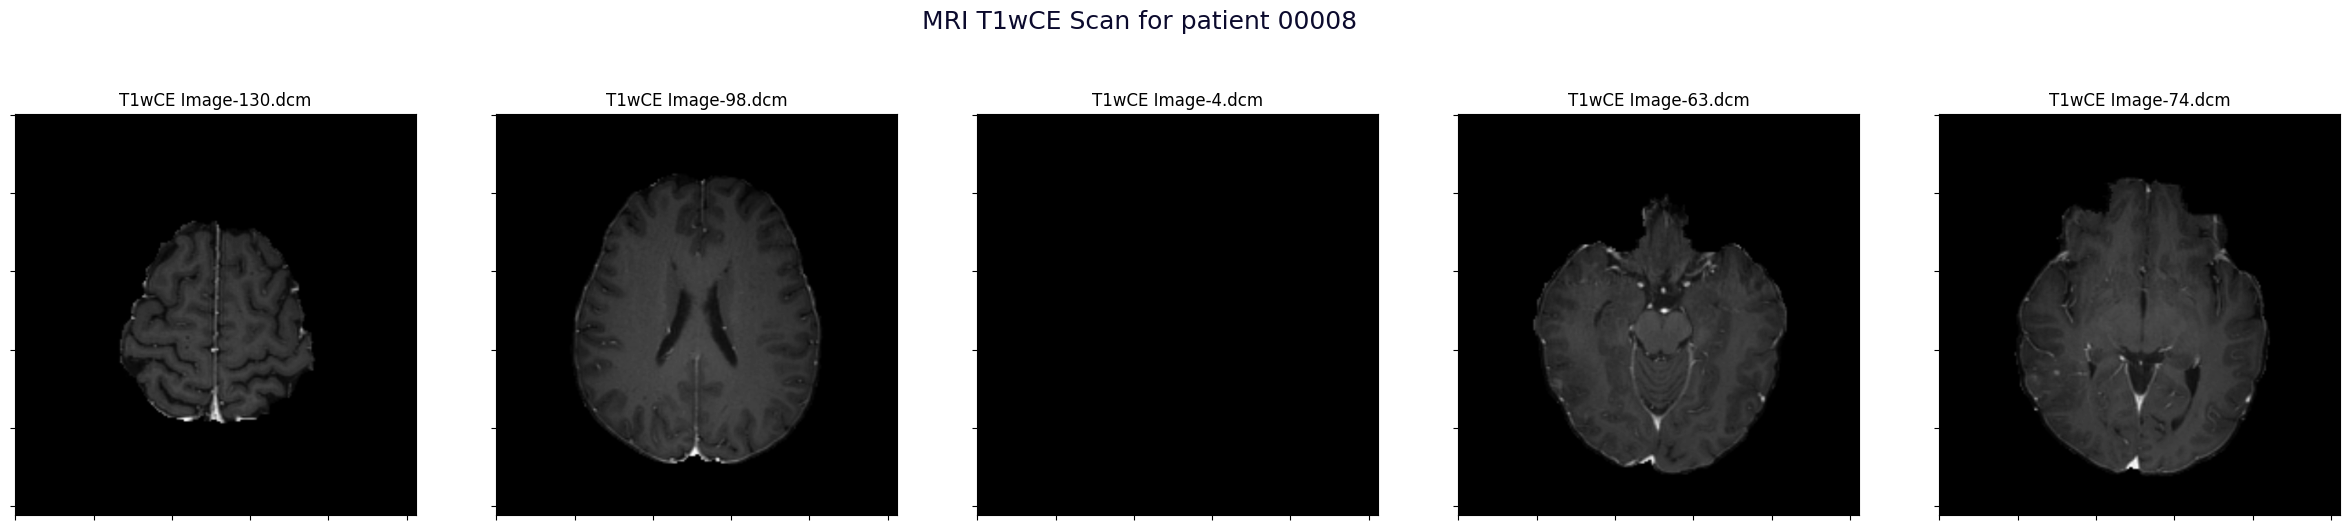

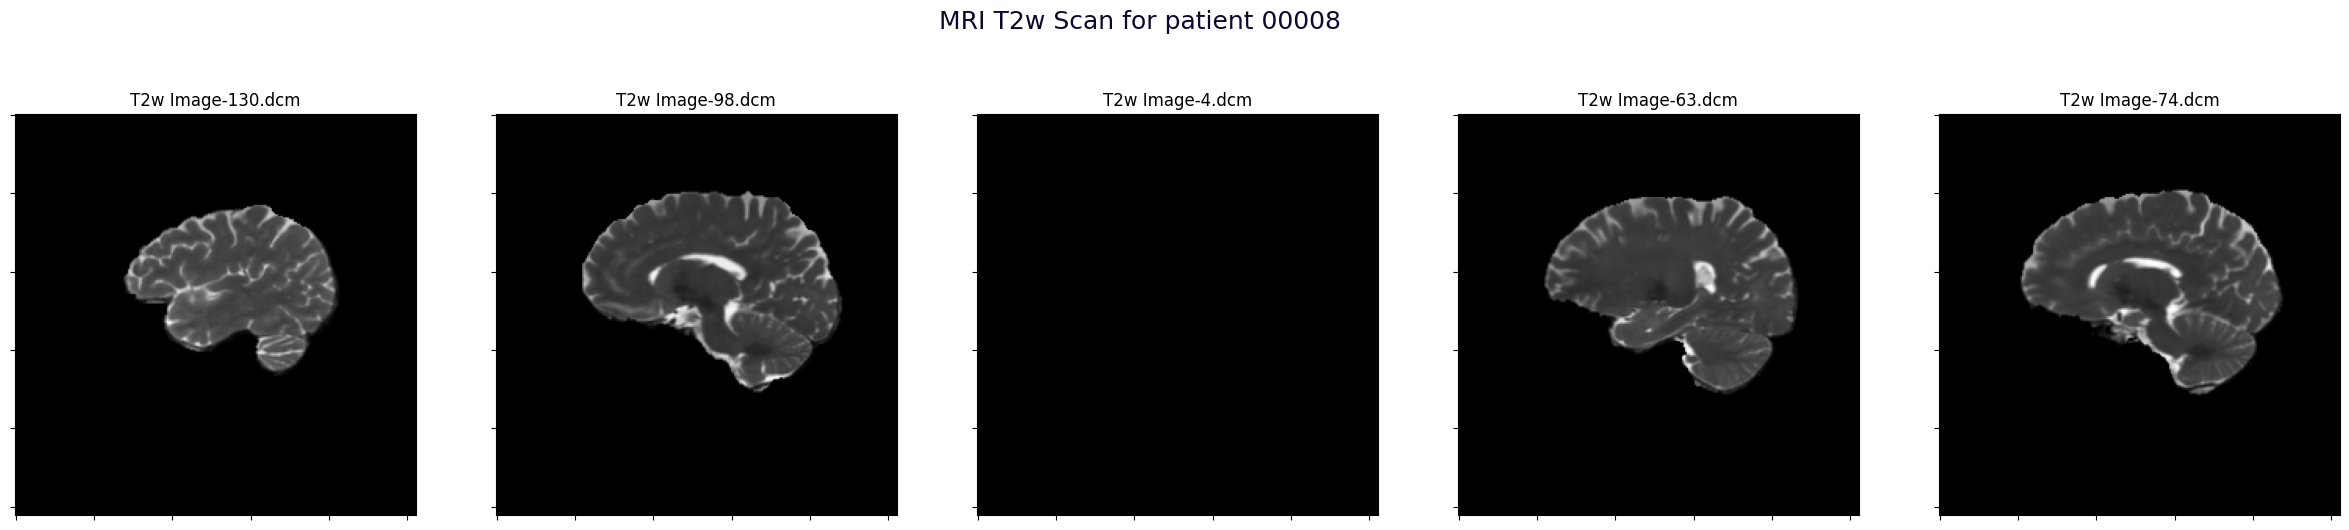

In [5]:
plot_examples(row = 5, cat = 'FLAIR')
plot_examples(row = 5, cat = 'T1w')
plot_examples(row = 5, cat = 'T1wCE')
plot_examples(row = 5, cat = 'T2w')

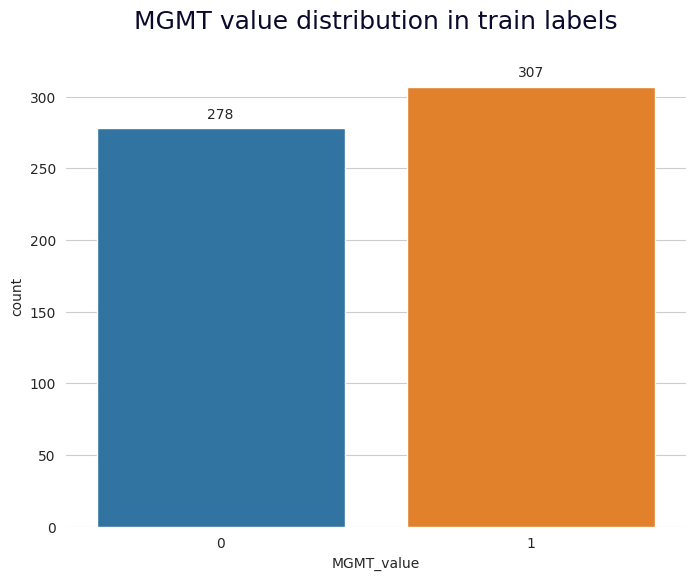

In [6]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,6))

ax = sns.countplot(data=train_labels, x="MGMT_value")
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center', 
        xytext = (0, 10), 
        textcoords = 'offset points')

sns.despine(left=True, bottom=True)
plt.title("MGMT value distribution in train labels\n",
          fontsize=18, color="#0b0a2d")
plt.show()

In [7]:
def brain_mri_preprocessor(dicom_path):
    # Load the DICOM image
    dicom_data = dicom.dcmread(dicom_path)
    img = dicom_data.pixel_array  # Convert DICOM to NumPy array

    # Normalize pixel values to 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold to create a binary mask (everything non-black is white)
    _, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)

    # Find contours of the white regions (brain)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the bounding box around the largest contour (assumed to be the brain)
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

        # Crop the image using the bounding box
        cropped_img = img[y:y+h, x:x+w]
        cropped_img = cv2.resize(cropped_img, (244, 244), interpolation = cv2.INTER_AREA)

        return cropped_img
    else:
        img = cv2.resize(img, (244, 244), interpolation = cv2.INTER_AREA) # Return original if no contours are found
        return img 

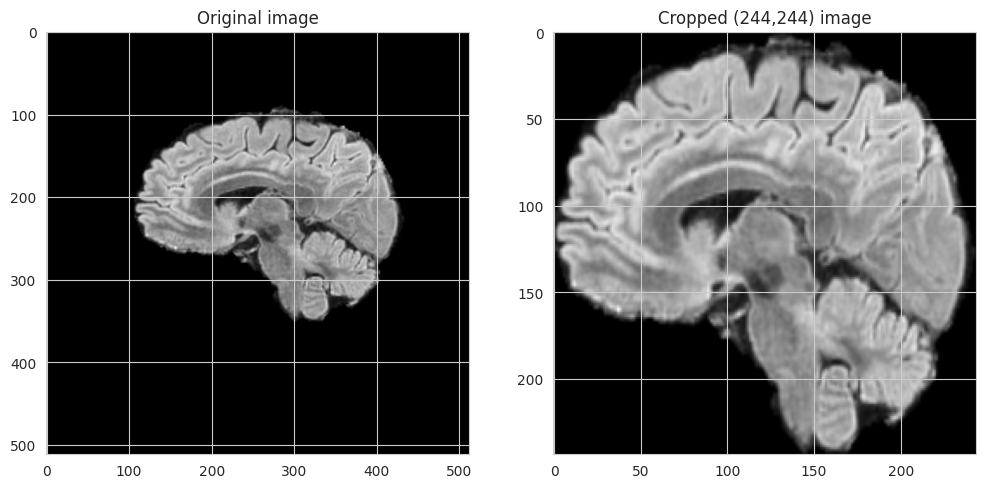

In [8]:
sample_img_path = ''.join([input_path, 'train/00008/FLAIR/Image-80.dcm'])
sample_img = dicom.dcmread(sample_img_path)
sample_img = sample_img.pixel_array

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
ax.imshow(sample_img, cmap='gray')
ax.set_title("Original image")

ax1 = plt.subplot(1,2,2)
img_cropped = brain_mri_preprocessor(sample_img_path)
ax1.imshow(img_cropped, cmap='gray')
ax1.set_title("Cropped (244,244) image")
plt.show()

In [9]:
scan_categories = ["FLAIR", "T1w", "T1wCE", "T2w"]

IMAGE_SIZE = 224
NUM_IMAGES = 24
BATCH_SIZE = 4

num_folds = 5
Selected_fold = 1 #1,2,3,4,5 

train_df = train_labels
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df["Fold"]="train"
train_df

,BraTS21ID,MGMT_value,BraTS21ID5,Fold
0,0,1,00000,train
1,2,1,00002,train
2,3,0,00003,train
3,5,1,00005,train
4,6,1,00006,train
...,...,...,...,...
580,1005,1,01005,train
581,1007,1,01007,train
582,1008,1,01008,train
583,1009,0,01009,train


In [10]:
test = test_labels
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015
3,27,0.5,00027
4,37,0.5,00037
...,...,...,...
82,826,0.5,00826
83,829,0.5,00829
84,833,0.5,00833
85,997,0.5,00997


In [11]:
def brain_mri_preprocessosr_3d(scan_id, mri_type, num_imgs, img_size, split):
    
        files = sorted(glob.glob(f"{input_path}{split}/{scan_id}/{mri_type}/*.dcm"), 
                   key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

        middle = len(files)//2
        num_imgs2 = num_imgs//2
    
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
    
        img3d = np.stack([brain_mri_preprocessor(f) for f in files[p1:p2]], axis=-1) 
    
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d,  n_zero), axis = -1)

            
        return img3d

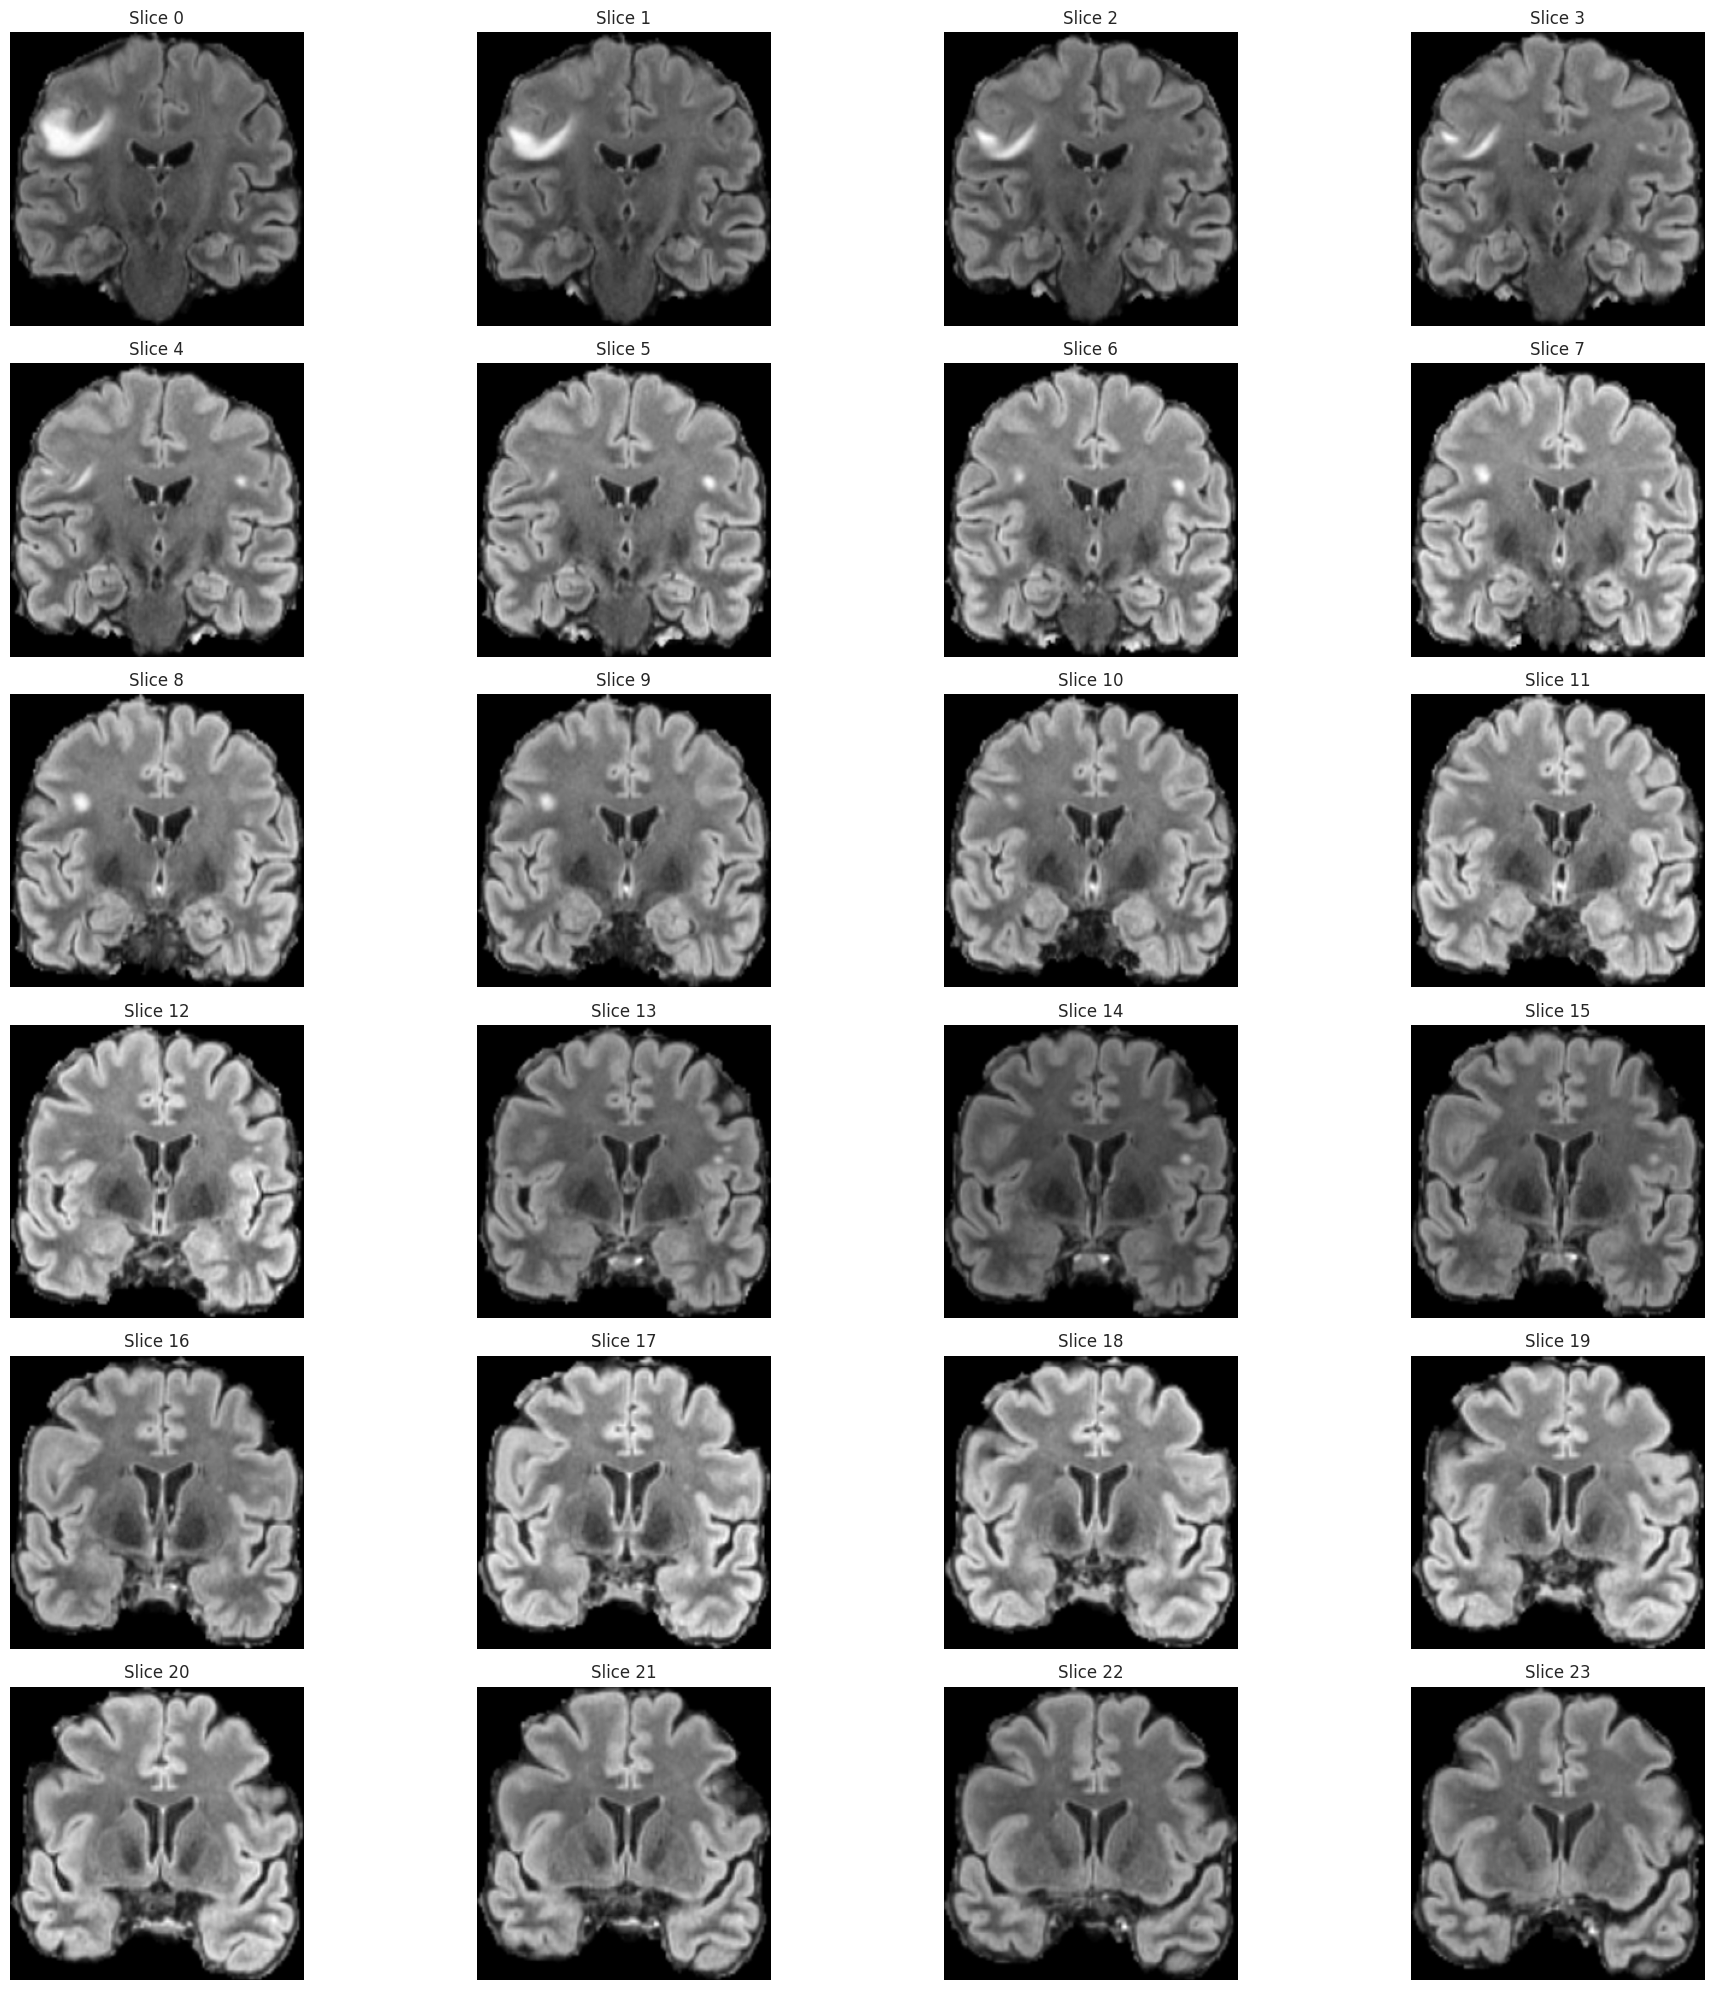

In [12]:
a = brain_mri_preprocessosr_3d("00046", "FLAIR", NUM_IMAGES, IMAGE_SIZE, "train")

fig, axes = plt.subplots(6, 4, figsize=(20, 20))

for i in range(NUM_IMAGES):
    row, col = divmod(i, 4)  # Get row and column index
    axes[row, col].imshow(a[:, :, i], cmap="gray")  # Show each slice
    axes[row, col].set_title(f"Slice {i}")
    axes[row, col].axis("off")  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()

In [13]:
sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)

X = train_df[['BraTS21ID']]
y = train_df[['MGMT_value']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_df.loc[valid, "Fold"] = "valid"
    fold_no += 1

df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"].iloc[:-1,:]

print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 468 -- df_valid= 116


In [14]:
from keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=BATCH_SIZE,shuffle=False):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            
            self.full_X_mri = []
            for mri_type in scan_categories:
                
                list_x =  [brain_mri_preprocessosr_3d(x, mri_type, NUM_IMAGES, IMAGE_SIZE, "train") for x in batch_paths]
                batch_X = np.stack(list_x, axis=0)
                self.full_X_mri.append(np.array(batch_X))
                
            return self.full_X_mri, np.array(batch_y)
            
        else:
            self.full_X_mri = []
            for mri_type in scan_categories:
                
                list_x =  load_dicom_images_3d(id_path,split="test",mri_type=mri_type)
                batch_X = np.stack(np.expand_dims(list_x, axis=0))
                self.full_X_mri.append(np.array(batch_X))
                
            return self.full_X_mri
    
    def on_epoch_end(self):
        
        if self.shuffle and self.is_train:
            
            ids_y = list(zip(self.idx, self.y))
            tf.random_shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [15]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
valid_dataset = Dataset(df_valid,batch_size=BATCH_SIZE)

Number of scan type is: 4
Dimension of the CT FLAIR scan is: (4, 244, 244, 24)
label= [1 1 0 1]




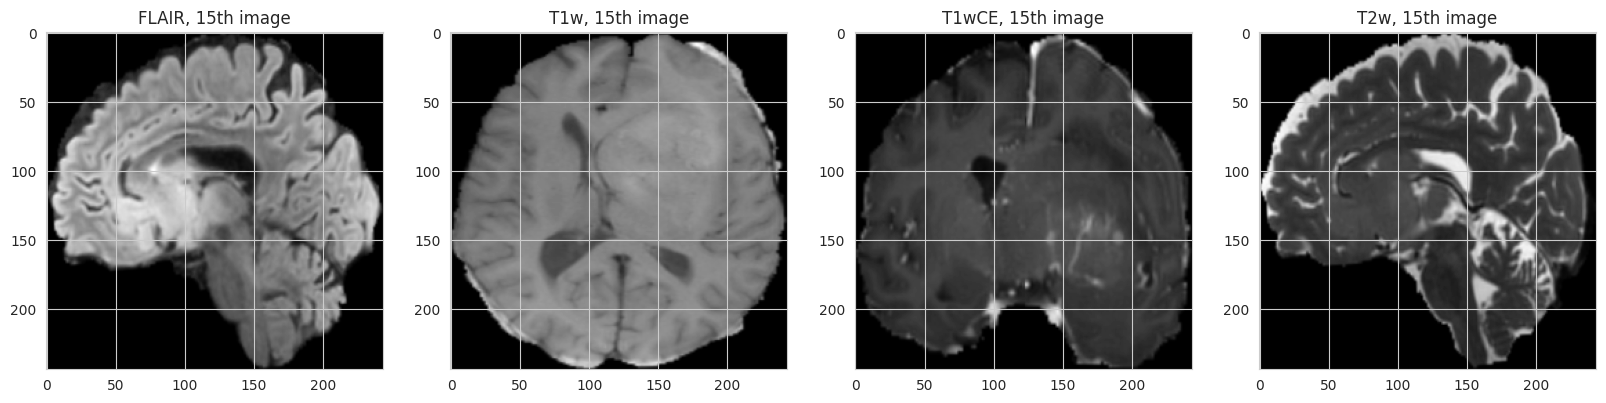

In [16]:
fig = plt.figure(figsize=(20,8))

for i in range(1):
    images, label = train_dataset[i]
    print("Number of scan type is:", len(images))
    print("Dimension of the CT FLAIR scan is:", images[1].shape)
    print("label=",label)
    print("\n")
    
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(images[0][1][:,:,15], cmap="gray")
    ax1.set_title("FLAIR, 15th image")
    
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(images[1][1][:,:,15], cmap="gray")
    ax2.set_title("T1w, 15th image")
    
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(images[2][1][:,:,15], cmap="gray")
    ax3.set_title("T1wCE, 15th image")
    
    ax4 = plt.subplot(1,4,4)
    ax4.imshow(images[3][1][:,:,15], cmap="gray")
    ax4.set_title("T2w, 15th image")